In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import jax
from numpyro.infer.reparam import TransformReparam
import numpyro.distributions as dist
from numpyro import handlers
import jax.numpy as jnp

numpyro.set_host_device_count(4)

## Contents

### 1. Motivation
### 2. Revision: Bayesian Logistic Regression
### 3. Ordered target
### 4. Ordered feature
### 5. Bonus

## 1. Motivation

In [2]:
# let's try doing it all with simulated data for now. kinda fun, really
# people are responding to a survey, and...
# let's get...political?
# salary...seniority?
# or is that data interesting enough already?
# dunno mate, dunno. really, don't know.

In [3]:
# sex -> hours worked
#     \       |
#      >     questionnaire answer

In [4]:
n_samples = 100
edu_level = np.random.choice([0, 1, 2, 3], size=n_samples, replace=True)
hours_worked = stats.norm(loc=2.0 + 3.0 * edu_level).rvs(size=n_samples)
q_answer_unconstrained = stats.norm(loc=hours_worked - edu_level).rvs(size=n_samples)
q_answer = np.where(
    q_answer_unconstrained < 3, 0, np.where(q_answer_unconstrained < 4.5, 1, 2)
)
data = pd.DataFrame(
    {
        "edu": edu_level,
        "hours": hours_worked,
        "q_answer": q_answer,
    }
)

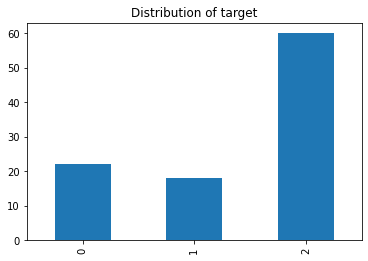

In [5]:
ax = data['q_answer'].value_counts().sort_index().plot.bar();
ax.set_title('Distribution of target');

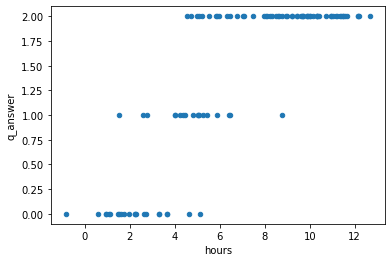

In [6]:
data.plot.scatter(x="hours", y="q_answer");

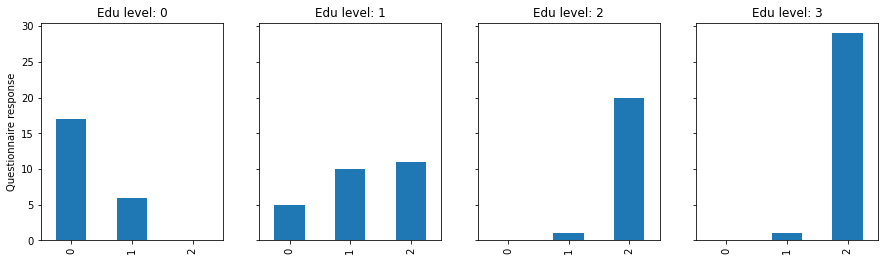

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=data["edu"].nunique(), sharey=True, figsize=(15, 4))
ax = ax.flatten()

for idx, edu_ in enumerate(sorted(data["edu"].unique())):
    data[data["edu"] == edu_]["q_answer"].value_counts().sort_index().reindex(
        np.arange(data["q_answer"].nunique())
    ).plot.bar(ax=ax[idx])
    ax[idx].set_title(f"Edu level: {edu_}")
    ax[idx].set_ylabel('Questionnaire response')

Looks like sex 1 is more likely to answer 2, and less likely to answer 0. And so, that people who work longer are more likely to answer 2.

## How to estimate the effect of both education and hours worked on survey response

Target:
- predict a real number y_unconstrained,
- identify 2 cut points along the real number line, c_1, c_2:
    if y_unconstrained <= c_1, then y = 0
    if c_1 < y_unconstrained <= c_2, then y = 1
    if y_unconstrained >= c_2, then y = 2

Features:
- hours: continuous
    find some coefficient beta_hours_worked to multiply by hours_worked;
- education level: ordered categorical
    beta_max_education_level effect of having the maximum education level
    we will take portions of it for lower levels of education

In [8]:
def model(hours_worked, edu_level, n_responses, q_answer=None):
    breakpoint()
    beta_hours_worked = numpyro.sample(
        'beta_hours_worked',
        numpyro.distributions.Normal(loc=0., scale=1.),
    )
    
    beta_edu_level = numpyro.sample(
        'beta_edu_level',
        numpyro.distributions.Normal(loc=0., scale=1.),
    )
    delta = numpyro.sample("delta", dist.Dirichlet(jnp.repeat(2, len(np.unique(edu_level))-1)))
    delta_j = jnp.pad(delta, (1, 0))
    delta_E = jnp.sum(jnp.where(jnp.arange(len(np.unique(edu_level))) <= edu_level[..., None], delta_j, 0), -1)
        
    q_answer_unconstrained = beta_hours_worked*hours_worked + beta_edu_level*delta_E
    
    with handlers.reparam(config={"cutpoints": TransformReparam()}):
        cutpoints = numpyro.sample(
            "cutpoints",
            dist.TransformedDistribution(
                dist.Dirichlet(np.ones(n_responses)),
                dist.transforms.SimplexToOrderedTransform(anchor_point=0.),
            ),
        )
    
    with numpyro.plate('obs', len(q_answer)):
        q_answer = numpyro.sample(
            'q_answer',
            numpyro.distributions.OrderedLogistic(
                q_answer_unconstrained,
                cutpoints,
            ),
            obs=q_answer,
        )

In [9]:
sampler = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(
    sampler,
    num_chains=4,
    num_samples=1000,
    num_warmup=1000,
)

mcmc.run(
    jax.random.PRNGKey(0),
    hours_worked=hours_worked,
    edu_level=edu_level,
    n_responses=len(np.unique(q_answer)),
    q_answer=q_answer,
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [10]:
mcmc.print_summary()


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta_edu_level     -0.08      0.91     -0.08     -1.51      1.48   2757.64      1.00
  beta_hours_worked      0.99      0.18      0.99      0.68      1.27   1599.74      1.00
  cutpoints_base[0]      0.95      0.04      0.96      0.90      0.99   2170.52      1.00
  cutpoints_base[1]      0.05      0.03      0.04      0.01      0.09   2321.39      1.00
  cutpoints_base[2]      0.01      0.01      0.00      0.00      0.01   1695.24      1.00
           delta[0]      0.33      0.18      0.31      0.04      0.60   3955.00      1.00
           delta[1]      0.33      0.18      0.31      0.04      0.60   4306.53      1.00
           delta[2]      0.34      0.18      0.32      0.04      0.61   3786.60      1.00

Number of divergences: 0


need to translate this into whatever the true education effect would have been

In [11]:
# wait a sec though...this isn't even close. But, maybe, it doesn't matter.

In [12]:
# plan
# 1) get the model together, check it actually works, and has a good story to tell
# 2) think of explanations / prior predictive checks / stories, all of that
# 3) practice, practice, practice. Need to have got here by the end of the weekend.

# don't stop, need to keep going!